In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import urllib

In [2]:
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

In [4]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [14]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

In [6]:
X_digits, y_digits = load_digits(return_X_y=True)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

In [9]:
from sklearn.linear_model import LogisticRegression

In [10]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [11]:
log_reg_score = log_reg.score(X_test, y_test)
log_reg_score

0.9688888888888889

if the logistic regression can have 96.8% accuracy, we can probably achieve better with K-Means as a preprocessing step
* create a pipeline that will first cluster the training set into 50 clusters and replace the images with their distances to the 50 clusters, then apply the logistic regression model

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

In [19]:
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50, random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [20]:
pipeline_score = pipeline.score(X_test, y_test)
pipeline_score

0.9777777777777777

A whopping 1% increase on accuracy, nice. 

In [21]:
1 - (1 - pipeline_score) / (1 - log_reg_score)

0.28571428571428414

error rate seemed to drop by 28.6%, not too bad. But that's only choosing the number of clusters k arbitrarily. We can perform the silhouette analysis or minimize the inertia, but the best value of k is simply the one that results in the best classification performance

In [22]:
from sklearn.model_selection import GridSearchCV

In [23]:
param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] END ...............................kmeans__n_clusters=2; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.0s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.0s
[CV] END ...............................kmeans_

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': range(2, 100)}, verbose=2)

In [24]:
grid_clf.best_params_

{'kmeans__n_clusters': 88}

In [25]:
grid_clf.score(X_test, y_test)

0.9822222222222222

Accuracy increased to 0.5%, noice. from 96% accuracy originally without clustering to 98% accuracy using the clustering algorithm.

### Semi-Supervised Learning

In [26]:
n_labeled = 50

In [27]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.8333333333333334

Not too terrible for only 50 labeled instances. obviously it wouldn't be high compared to our original 96% as supervised learning

We cluster the training set into 50 clusters, then for each clusters, we find the image closest to the centroid

In [28]:
k = 50

In [29]:
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

Saving figure representative_images_diagram


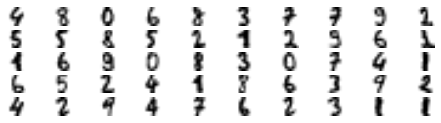

In [30]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

save_fig("representative_images_diagram", tight_layout=False)
plt.show()

In [31]:
y_train[representative_digit_idx]

array([4, 8, 0, 6, 8, 3, 7, 7, 9, 2, 5, 5, 8, 5, 2, 1, 2, 9, 6, 1, 1, 6,
       9, 0, 8, 3, 0, 7, 4, 1, 6, 5, 2, 4, 1, 8, 6, 3, 9, 2, 4, 2, 9, 4,
       7, 6, 2, 3, 1, 1])

In [34]:
y_representative_digits = np.array([
    4, 8, 0, 6, 8, 3, 7, 7, 9, 2,
    5, 5, 8, 5, 2, 1, 2, 9, 6, 1, 
    1, 6, 9, 0, 8, 3, 0, 7, 4, 1, 
    6, 5, 2, 4, 1, 8, 6, 3, 9, 2, 
    4, 2, 9, 4, 7, 6, 2, 3, 1, 1])

In [35]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.9177777777777778

From 83% to 91.7% isn't too bad for training the model on 50 instances. It's costly and tedious to label these instances manually, but it's a good idea to make them label representative instances rather than random instances

we can propagate the labels to all the other instances in the same cluster

In [36]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [37]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [38]:
log_reg.score(X_test, y_test)

0.9333333333333333

Good 2% accuracy boost. But we can propagate the labels to the instances closest to the centroid, since we're including some outliers.\
We propagate the labels to the 75th percentile closest to the centroid

In [39]:
percentile_closest = 75

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [40]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [41]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [42]:
log_reg.score(X_test, y_test)

0.9333333333333333

Nothing changed, but that's only because we have a small subset of datas to work with. When working with many datasets, we can hope to achieve even a stronger accuracy score

In [43]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.9741035856573705